Calculate the light curves of TNO occultations based on object size, distance, and apparent stellar size

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

In [3]:
# Load csv file with LUT. Create numpy interpolator
lut_array = np.loadtxt('occultation_intensity_lut.csv', delimiter=',', skiprows=1)
interpolator = scipy.interpolate.CloughTocher2DInterpolator(lut_array[:, :2], lut_array[:, 2])

In [4]:
# Per Eqs. 12 in Rocques & Moncuquet 2000
def intensity_with_stellar_disk(r, R_TNO, R_star, n_steps=50):
    '''Intensity profile for a TNO occultation of a star with projected radius R_star.

    Parameters:
    ----------
    r : float
        Distance from the center of the shadow in Fresnel units.
    R_TNO : float
        Radius of the TNO in Fresnel units.
    R_star : float
        Projected radius of the star at the TNO distance, in Fresnel units.
    n_steps : int (default 50)
        Number of steps to use in each variable of the 2D numerical integration.
    '''
    if R_star == 0:
        return interpolator(r, R_TNO)
    s_vals = np.linspace(0, R_star, n_steps)
    theta_vals = np.linspace(0, np.pi, n_steps)
    s_vals_long = s_vals.repeat(n_steps)
    theta_vals_long = np.array([theta_vals]).repeat(n_steps, axis=0).flatten()
    distance_vals = np.sqrt(r**2 + s_vals_long**2 + 2 * r * s_vals_long * np.cos(theta_vals_long))
    grid_x, grid_y = np.meshgrid(distance_vals, R_TNO)
    integrand_vals = interpolator((grid_x, grid_y))
    integral_result = np.sum(integrand_vals * s_vals_long)
    normalization_factor = (2 / (np.pi * R_star**2)) * (np.pi / n_steps) * (R_star / n_steps)
    return normalization_factor * integral_result

v_intensity = np.vectorize(intensity_with_stellar_disk)

# Compute intensity profiles for various TNO and projected star radii
r_list = np.linspace(0, 15, 250)
r_star_list = [0.1, 1, 5]
r_tno_list = [0.1, 1, 10]
intensities = np.zeros((len(r_tno_list), len(r_star_list), len(r_list)))
for i, r_tno in enumerate(r_tno_list):
    for j, r_star in enumerate(r_star_list):
        intensities[i, j] = v_intensity(r_list, r_tno, r_star)

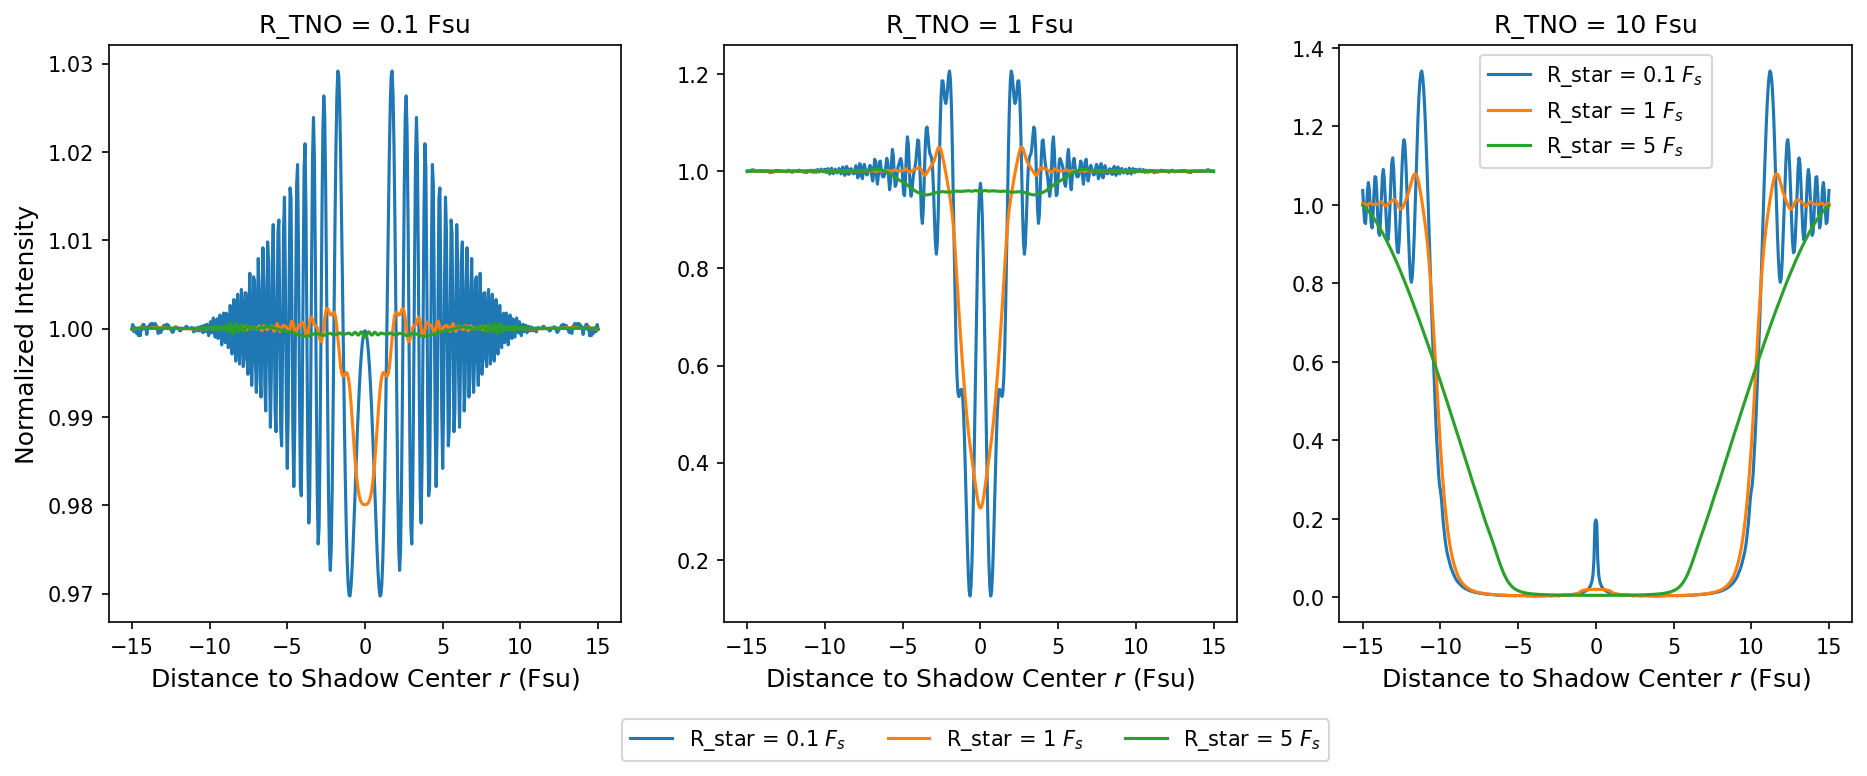

In [5]:
# Create three axes, each with a different r_tno and plotting the intensity profiles for all 5 r_star values
%matplotlib inline
# set dpi 200
plt.rcParams['figure.dpi'] = 150
# Make all axis labels and grid labels
plt.rcParams.update({'axes.labelsize': 'large'})
plt.rcParams.update({'axes.titlesize': 'large'})
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    for j in range(3):
        r_list_both = np.concatenate((-r_list[::-1], r_list))
        intensities_both = np.concatenate((intensities[i, j][::-1], intensities[i, j]))
        ax[i].plot(r_list_both, intensities_both, label=f"R_star = {r_star_list[j]}" + r' $F_s$')
    ax[i].set_xlabel(r'Distance to Shadow Center $r$ (Fsu)')
    ax[i].set_title(f'R_TNO = {r_tno_list[i]} Fsu')

ax[0].legend( bbox_to_anchor=(2.4, -0.15), ncol=3)
ax[0].set_ylabel('Normalized Intensity')
plt.legend()
plt.show()

In [6]:
def tno_occult_lightcurve(r_TNO, theta_star, d_TNO=40, wavelength=500,
                          omega=0, y=0, sampling_rate=10, n_steps=50,
                          smoothing_points=10):
    '''Create a synthetic light curve for a TNO occultation of a star.
    
    Parameters:
    ----------
    R_TNO : float
        Radius of the TNO in km.
    theta_star : float
        Angular radius of the star, in milliarcesconds.
    d_TNO : float (default 40)
        Distance from the Earth to the TNO in AU.
    wavelength : float (default 500)
        Wavelength of observation in nm.
    omega : float (default 0)
        Angle between solar opposition and the TNO line of sight, in degrees.
    y : float (default 0)
        Minimum distance from the star line of sight to the TNO center, in km.
    sampling_rate : int (default 10)
        Temporal sampling rate of the light curve, in Hz.
    n_steps : int (default 50)

    Returns:
    ---------
    result_dict : dict
        Dictionary with the following keys:
        - r_star_fsu : float
            Projected radius of the star at the TNO distance, in Fresnel units.
        - r_tno_fsu : float
            Radius of the TNO in Fresnel units.
        - y_fsu : float
            Minimum distance from the star line of sight to the TNO center, in Fresnel units.
        - times : array
            Array of times in seconds.
        - r_points : array
            Array of distances from the shadow center in Fresnel units.
        - intensities : array
            Array of normalized intensities at each time point.
    '''

    # Calculate Fresnel scale, in km
    fsu = np.sqrt(wavelength * 1e-12 * d_TNO * 1.496e8 / 2)
    # Convert TNO and star sizes to Fresnel scale units
    R_TNO_fsu = r_TNO / fsu
    R_star_fsu = theta_star / 1000 / 3600 / 180 * np.pi * d_TNO * 1.496e8 / fsu
    y_fsu = y / fsu
    if R_star_fsu + np.sqrt(y_fsu **2 + R_TNO_fsu ** 2) > 15:
        raise ValueError("System size too large--keep it under 15 Fsu.")

    # Calculate the velocity of the TNO in the sky plane, in fsu/s
    v_earth = 29.8 / fsu
    v_object = v_earth * (np.cos(omega * np.pi / 180) - np.sqrt(1 / d_TNO))
    # Time it takes for r to go from -15 to 15 fsu
    duration = 30 / v_object
    t_spacing = 1 / sampling_rate
    t_points_fine = np.arange(0, duration, t_spacing / smoothing_points)
    t_points = t_points_fine[::smoothing_points]
    x_points = -15 + v_object * t_points_fine
    r_points = np.sqrt(x_points**2 + y_fsu**2)
    intensity_points = np.zeros_like(t_points)
    intensity_points_fine = v_intensity(r_points, R_TNO_fsu, R_star_fsu, n_steps=n_steps)
    for j in range(len(t_points)):
        intensity_points[j] = np.mean(intensity_points_fine[j * smoothing_points: (j + 1) * smoothing_points])
    result_dict = {'r_star_fsu': R_star_fsu, 'r_tno_fsu': R_TNO_fsu, 'y_fsu': y_fsu, 'times': t_points,
                   'r_points': r_points, 'intensities': intensity_points, 'velocity': v_object,
                   'times_fine': t_points_fine, 'intensities_fine': intensity_points_fine}
    return result_dict


Time to compute light curve: 0.153580904006958 s
0.7978836279039113 0.2025415169808539 0.0 14.717443123976551


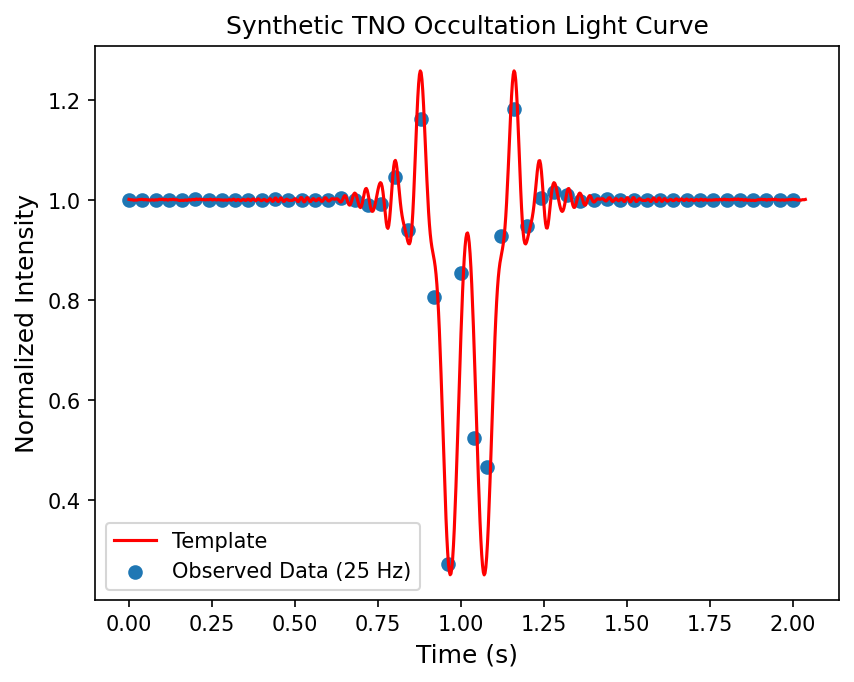

In [7]:
import time
start = time.time()
lightcurve_dict = tno_occult_lightcurve(r_TNO=1, theta_star=0.01, d_TNO=35, omega=38, wavelength=600, y=0., sampling_rate=50, n_steps=20, smoothing_points=8)
stop = time.time()
print('Time to compute light curve:', stop - start, 's')
print(lightcurve_dict['r_tno_fsu'], lightcurve_dict['r_star_fsu'], lightcurve_dict['y_fsu'], lightcurve_dict['velocity'])
plt.plot(lightcurve_dict['times_fine'], lightcurve_dict['intensities_fine'], color='red', label='Template')
plt.scatter(lightcurve_dict['times'][::2], lightcurve_dict['intensities'][::2], label='Observed Data (25 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Intensity')
plt.title('Synthetic TNO Occultation Light Curve')
plt.legend()
plt.show()

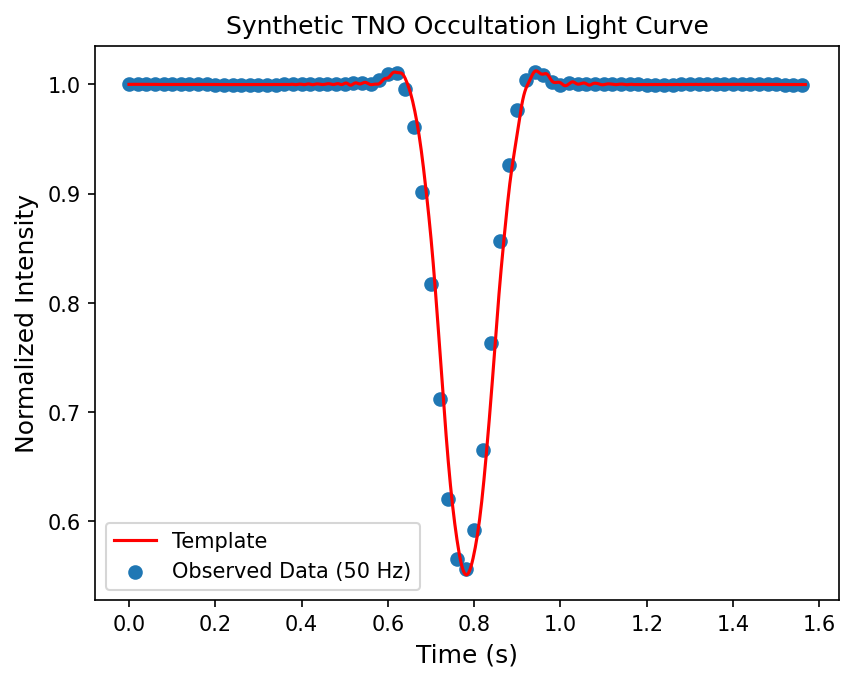

TNO radius in Fresnel scale units: 0.7728310917567678
Star radius in Fresnel scale units: 0.9809098483797697
Offset distance in Fresnel scale units: 0.0


In [29]:
def calculate_pivot_wavelength(wavelengths, transmission):
    """
    Calculate the pivot wavelength given arrays of wavelengths and transmission values.

    Parameters:
    wavelengths (numpy array): Array of wavelengths (in angstroms or nanometers).
    transmission (numpy array): Array of transmission or response values corresponding to the wavelengths.

    Returns:
    pivot_wavelength (float): The calculated pivot wavelength.
    """
    # Convert wavelengths to numpy arrays if not already
    wavelengths = np.array(wavelengths)
    transmission = np.array(transmission)
    
    # Calculate the numerator: ∫ T(λ) * λ dλ
    numerator = np.trapz(transmission * wavelengths, wavelengths)
    
    # Calculate the denominator: ∫ T(λ) / λ dλ
    denominator = np.trapz(transmission / wavelengths, wavelengths)
    
    # Calculate the pivot wavelength
    pivot_wavelength = np.sqrt(numerator / denominator)
    
    return pivot_wavelength

def broadband_tno_lightcurve(r_TNO, theta_star, d_TNO=40, wavelengths=np.array([500]),
                          wavelengths_weights=np.array([1]),
                          omega=0, y=0, sampling_rate=10, n_steps=50,
                          smoothing_points=10):
    '''Create a synthetic light curve for a TNO occultation of a star.
    
    Parameters:
    ----------
    R_TNO : float
        Radius of the TNO in km.
    theta_star : float
        Angular radius of the star, in milliarcesconds.
    d_TNO : float (default 40)
        Distance from the Earth to the TNO in AU.
    wavelengths : array (default np.array([500]))
        Wavelengths of observation in nm.
    wavelengths_weights : array (default np.array([1]))
        Weights of each wavelength.
    omega : float (default 0)
        Angle between solar opposition and the TNO line of sight, in degrees.
    y : float (default 0)
        Minimum distance from the star line of sight to the TNO center, in km.
    sampling_rate : int (default 10)
        Temporal sampling rate of the light curve, in Hz.
    n_steps : int (default 50)

    Returns:
    ---------
    result_dict : dict
        Dictionary with the following keys:
        - r_star_fsu : float
            Projected radius of the star at the TNO distance, in Fresnel units.
        - r_tno_fsu : float
            Radius of the TNO in Fresnel units.
        - y_fsu : float
            Minimum distance from the star line of sight to the TNO center, in Fresnel units.
        - times : array
            Array of times in seconds.
        - r_points : array
            Array of distances from the shadow center in Fresnel units.
        - intensities : array
            Array of normalized intensities at each time point.
    '''
    # Calculate the pivot wavelength
    if len(wavelengths) != len(wavelengths_weights):
        raise ValueError("The number of wavelengths and weights must be the same.")
    if len(wavelengths) == 1:
        pivot_wavelength = wavelengths[0]
    else:
        pivot_wavelength = calculate_pivot_wavelength(wavelengths, wavelengths_weights)
    
    # Calculate Fresnel scale at the pivot wavelength, in km
    fsu_pivot = np.sqrt(pivot_wavelength * 1e-12 * d_TNO * 1.496e8 / 2)
    # Convert TNO and star sizes to Fresnel scale units
    R_TNO_fsu_pivot = r_TNO / fsu_pivot
    R_star_fsu_pivot = theta_star / 1000 / 3600 / 180 * np.pi * d_TNO * 1.496e8 / fsu_pivot
    y_fsu_pivot = y / fsu_pivot

    # Calculate the velocity of the TNO in the sky plane, in fsu/s (at the pivot wavelength)
    v_earth = 29.8 / fsu_pivot
    v_object = v_earth * (np.cos(omega * np.pi / 180) - np.sqrt(1 / d_TNO))
    # Time it takes for r to go from -15 to 15 pivot wavelength fsu
    duration = 30 / v_object
    t_spacing = 1 / sampling_rate
    t_points_fine = np.arange(0, duration, t_spacing / smoothing_points)
    t_points = t_points_fine[::smoothing_points]

    fsu_array = np.sqrt(wavelengths * 1e-12 * d_TNO * 1.496e8 / 2)
    R_TNO_fsu_array = r_TNO / fsu_array
    R_star_fsu_array = theta_star / 1000 / 3600 / 180 * np.pi * d_TNO * 1.496e8 / fsu_array
    y_fsu_array = (y / fsu_array).repeat(len(t_points_fine)).reshape(len(wavelengths), len(t_points_fine))
    system_size_array = [R_star_fsu + np.sqrt(y_fsu **2 + R_TNO_fsu ** 2) for
                        R_star_fsu, y_fsu, R_TNO_fsu in zip(R_star_fsu_array, y_fsu_array, R_TNO_fsu_array)]
    if np.max(system_size_array) > 15:
        raise ValueError("System size too large--keep it under 15 Fsu at all wavelengths.")
    
    v_object_array = 29.8 / fsu_array * (np.cos(omega * np.pi / 180) - np.sqrt(1 / d_TNO))
    x_points_pivot = -15 + v_object * t_points_fine
    start_point_array = -15 / fsu_pivot * fsu_array
    x_points_array = np.array([start_point_array[i] + v_object_array[i] * t_points_fine for i in range (len(wavelengths))])
    r_points_pivot = np.sqrt(x_points_pivot ** 2 + y_fsu_pivot ** 2)
    r_points_array = np.sqrt(x_points_array ** 2 + y_fsu_array ** 2)
    intensity_points_fine = np.zeros(len(t_points_fine))
    intensity_points = np.zeros_like(t_points)
    for i in range(len(wavelengths)):
        intensity_points_fine += wavelengths_weights[i] * v_intensity(r_points_array[i], R_TNO_fsu_array[i], R_star_fsu_array[i], n_steps=n_steps)
    # Normalize the intensity points
    intensity_points_fine /= np.mean(intensity_points_fine[:5])
    for j in range(len(t_points)):
        intensity_points[j] = np.mean(intensity_points_fine[j * smoothing_points: (j + 1) * smoothing_points])
    result_dict = {'r_star_fsu': R_star_fsu_pivot, 'r_tno_fsu': R_TNO_fsu_pivot, 'y_fsu': y_fsu_pivot, 'times': t_points,
                   'intensities': intensity_points, 'velocity': v_object, 'r_points': r_points_pivot,
                   'times_fine': t_points_fine, 'intensities_fine': intensity_points_fine, 'lambda_pivot': pivot_wavelength}
    return result_dict

lightcurve = broadband_tno_lightcurve(r_TNO=1, theta_star=0.05, d_TNO=35, omega=0, wavelengths=np.array([600, 620, 640, 660, 680]), wavelengths_weights=np.array([1, 1, 1, 1, 1]), y=0, sampling_rate=50, n_steps=50, smoothing_points=8)
plt.plot(lightcurve['times_fine'], lightcurve['intensities_fine'], color='red', label='Template')
plt.scatter(lightcurve['times'], lightcurve['intensities'], label='Observed Data (50 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Intensity')
plt.title('Synthetic TNO Occultation Light Curve')
plt.legend()
plt.show()
# Print TNO and star sizes in Fresnel scale units
print('TNO radius in Fresnel scale units:', lightcurve['r_tno_fsu'])
print('Star radius in Fresnel scale units:', lightcurve['r_star_fsu'])
print('Offset distance in Fresnel scale units:', lightcurve['y_fsu'])

In [9]:
x = np.array([1, 2, 3])
np.sqrt(x)

array([1.        , 1.41421356, 1.73205081])

In [31]:
# Print times so they display as a list that I can copy to python
print(list(lightcurve['times']))
print(list(lightcurve['intensities']))

[0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7000000000000001, 0.72, 0.74, 0.76, 0.78, 0.8, 0.8200000000000001, 0.84, 0.86, 0.88, 0.9, 0.92, 0.9400000000000001, 0.96, 0.98, 1.0, 1.02, 1.04, 1.06, 1.08, 1.1, 1.12, 1.1400000000000001, 1.16, 1.18, 1.2, 1.22, 1.24, 1.26, 1.28, 1.3, 1.32, 1.34, 1.36, 1.3800000000000001, 1.4000000000000001, 1.42, 1.44, 1.46, 1.48, 1.5, 1.52, 1.54, 1.56]
[1.0000134698192191, 1.0000364392259375, 1.0000242504190036, 0.9999340083840196, 0.9998933258969123, 0.9999009353523838, 0.9999141473727281, 0.9999505354482887, 0.9999600023166005, 0.9998960228735443, 0.9998289730326697, 0.9997981021311697, 0.9998261833075585, 0.9998529667195817, 0.9998376775279177, 0.9998040404565443, 0.9998412111089414, 0.9998614759772817, 0.9999114404851637, 0.9999845788324442, 1.0000527647673763, 1.0000630744992192, 1.000076026533